<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/prepare_monthly_historical_seasonal_future_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus-climate project

https://github.com/Vizzuality/copernicus-climate-data

`Edward P. Morris (vizzuality.)`

## Description
This notebook creates monthly historical summaries for maximum and minimum `pet`, surface temperature, coldsnaps and heatwaves. Future seasonal and longterm summaries are also created. All data arrays for each theme are grouped and written to GCS as Zarr groups for further processing.  

## TODO
+ check dtypes and convert to simpler types; float64 to float32 reduces array size by 2. see https://xarray.pydata.org/en/stable/io.html#writing-encoded-data
+ Transpose so order is min to max variation
```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

Instructions for setting up the computing environment.

In [0]:
%%bash
# Remove sample_data
rm -r sample_data

## Linux dependencies

Instructions for adding linux (including node, ect.) system packages.

``` 
!apt install -q -y <package-name>
!npm install -g <package-name>
```

In [2]:
# Packages for projections and geospatial processing
!apt install -q -y libspatialindex-dev libproj-dev proj-data proj-bin libgeos-dev

Reading package lists...
Building dependency tree...
Reading state information...
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev libspatialindex-c4v5 libspatialindex-dev
  libspatialindex4v5 proj-bin
0 upgraded, 6 newly installed, 0 to remove and 29 not upgraded.
Need to get 860 kB of archives.
After this operation, 5,014 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4

## Python packages

Consider using package versions to ensure nothing changes.

`!pip install -q <package-name>`

In [0]:
# connect to Google cloud storage
!pip install -q gcsfs 

In [4]:
# geospatial tools
!pip install -q country-converter rtree geopandas shapely fiona

     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 931kB 47.1MB/s 
     |████████████████████████████████| 14.7MB 300kB/s 
     |████████████████████████████████| 10.9MB 55.1MB/s 


In [5]:
# netcdf, xarray, xclim, and Zarr tools
!pip install -q cftime netcdf4 nc-time-axis zarr xarray xclim rioxarray regionmask sparse

     |████████████████████████████████| 327kB 4.9MB/s 
     |████████████████████████████████| 4.1MB 9.6MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 3.7MB 50.3MB/s 
     |████████████████████████████████| 122kB 52.8MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 3.8MB 60.2MB/s 
     |████████████████████████████████| 174kB 46.1MB/s 
     |████████████████████████████████| 194kB 42.4MB/s 
     |████████████████████████████████| 18.2MB 238kB/s 
     |████████████████████████████████| 14.4MB 314kB/s 
     |████████████████████████████████| 634kB 57.7MB/s 
     |████████████████████████████████| 225kB 53.3MB/s 
     |████████████████████████████████| 501kB 57.5MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 


In [6]:
# Show python package versions
!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
affine                   2.3.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asciitree                0.3.3          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boltons                  20.1.0         
boto            

## Authorisation

Setting up connections and authorisation to cloud services.

### Google Cloud

This can be done in the URL or via adding service account credentials.

If you do not share the notebook, you can mount your Drive and and transfer credentials to disk. Note if the notebook is shared you always need to authenticate via URL.  

In [0]:
# Set Google Cloud information
gc_project = "skydipper-196010"
gc_creds = "skydipper-196010-f842645fd0f3.json"
gc_user = "edward-morris@skydipper-196010.iam.gserviceaccount.com"
gcs_prefix = "gs://copernicus-climate"

In [0]:
# For auth WITHOUT service account
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#from google.colab import auth
#auth.authenticate_user()
#!gcloud config set project {project_id}

In [0]:
# If the notebook is shared
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# If Drive is mounted, copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/{gc_creds}" "/root/.{gc_creds}"

In [11]:
# Auth WITH service account
!gcloud auth activate-service-account {gc_user} --key-file=/root/.{gc_creds} --project={gc_project}


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


In [12]:
# Test GC auth
!gsutil ls {gcs_prefix}

gs://copernicus-climate/heatwaves_historical_Basque.zip
gs://copernicus-climate/heatwaves_longterm_Basque.zip
gs://copernicus-climate/spain.zarr.zip
gs://copernicus-climate/coldsnaps/
gs://copernicus-climate/data_for_PET/
gs://copernicus-climate/dataset/
gs://copernicus-climate/european-nuts-lau-geometries.zarr/
gs://copernicus-climate/heatwaves/
gs://copernicus-climate/pet/
gs://copernicus-climate/spain.zarr/
gs://copernicus-climate/tasmax/
gs://copernicus-climate/tasmin/
gs://copernicus-climate/to_delete/
gs://copernicus-climate/zonal_stats/


# Utils

Generic helper functions used in the subsequent processing. For easy navigation each function seperated into a section with the function name.

## copy_gcs

In [0]:
import os
import subprocess

def copy_gcs(source_list, dest_list, opts=""):
  """
  Use gsutil to copy each corresponding item in source_list
  to dest_list.

  Example:
  copy_gcs(["gs://my-bucket/data-file.csv"], ["."])

  """
  for s, d  in zip(source_list, dest_list):
    cmd = f"gsutil -m cp -r {opts} {s} {d}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
  print("Finished copy")

## list_paths

In [0]:
import glob
import subprocess

def list_paths(uri_prefix, dir_path, file_pattern="*", gsutil=True, return_dir_path=True):
        ''' Creates a list of full paths 
    
        Uses glob regex rules allowing flexible patterns
    
        Parameters
        ----------
        uri_prefix : str
            The (GCS) uri prefix.
        dir_path : str
            Directory path, can use regex.
        file_pattern : str
            File pattern for glob searching.
        gsutil : bool
            Use gsutil, default is True.
        return_dir_path : bool
            Return directory path relative to uri_prefix, default is True.        
    
        Returns
        -------
        List of path strings.
        
        Examples
        --------
        # Requires authentication
        #list_paths("gs://skydipper-water-quality", "cloud-masks/*", "*.tif", True, False)
        '''
        p = f"{uri_prefix}/{dir_path}/{file_pattern}"
        print(f"Searching {p}")
        if not gsutil:
          out = glob.glob(p)
        if gsutil:
          cmd = f"gsutil ls {p}"
          out = subprocess.check_output(cmd, shell=True).decode('utf8').split('\n')
          out.pop(-1)
        if return_dir_path:
          out = [f.split(uri_prefix)[1] for f in out]  
        print(f"Found {len(out)} path(s)")
        return out

#path_list = list_paths("gs://skydipper-water-quality", "cloud-masks/*", "*.tif", True, True)
#print(path_list[0])



## mkdirs

In [0]:
from pathlib import Path

def mkdirs(dirs_list, exist_ok=True):
  """ Create nested directories
  """
  for p in dirs_list:
    Path(p).mkdir(parents=True, exist_ok=exist_ok)


## unzip_to_dir

In [0]:
from zipfile import ZipFile 
  
def unzip_to_dir(source_list, dest_list, dry_run=False, view_contents=False):
  for s,d in zip(source_list, dest_list):
    # opening the zip file in READ mode 
    with ZipFile(s, 'r') as archive: 
      if dry_run:
        print(f"Dry run Extracting {s} to {d}")
        if view_contents:
          # printing all the contents of the zip file 
          archive.printdir()
      else:
        # extracting all the files 
        print(f"Extracting {s} to {d}") 
        archive.extractall(path=d) 
      print('Done!') 


## extract_string

In [0]:
import os
def extract_string(file_path, split, index):
  """
  Get string by splitting path
  
  @arg file_path The file path string to split
  @arg split Caracter to split path on
  @index Index integer to retain

  @return A string
  """ 
  return os.path.splitext(file_path)[0].split(split)[index]

## unchunk_dataset

In [0]:
# unchunk coords
# from xcube
import json
import os.path
from typing import List, Sequence

import numpy as np
import xarray as xr
import zarr


def unchunk_dataset(dataset_path: str, var_names: Sequence[str] = None, coords_only: bool = False):
    """
    Unchunk dataset variables in-place.
    :param dataset_path: Path to ZARR dataset directory.
    :param var_names: Optional list of variable names.
    :param coords_only: Un-chunk coordinate variables only.
    """

    is_zarr = os.path.isfile(os.path.join(dataset_path, '.zgroup'))
    if not is_zarr:
        raise ValueError(f'{dataset_path!r} is not a valid Zarr directory')

    with xr.open_zarr(dataset_path) as dataset:
        if var_names is None:
            if coords_only:
                var_names = list(dataset.coords)
            else:
                var_names = list(dataset.variables)
        else:
            for var_name in var_names:
                if coords_only:
                    if var_name not in dataset.coords:
                        raise ValueError(f'variable {var_name!r} is not a coordinate variable in {dataset_path!r}')
                else:
                    if var_name not in dataset.variables:
                        raise ValueError(f'variable {var_name!r} is not a variable in {dataset_path!r}')

    _unchunk_vars(dataset_path, var_names)


def _unchunk_vars(dataset_path: str, var_names: List[str]):
    for var_name in var_names:
        var_path = os.path.join(dataset_path, var_name)

        # Optimization: if "shape" and "chunks" are equal in ${var}/.zarray, we are done
        var_array_info_path = os.path.join(var_path, '.zarray')
        with open(var_array_info_path, 'r') as fp:
            var_array_info = json.load(fp)
            if var_array_info.get('shape') == var_array_info.get('chunks'):
                continue

        # Open array and remove chunks from the data
        var_array = zarr.convenience.open_array(var_path, 'r+')
        if var_array.shape != var_array.chunks:
            # TODO (forman): Fully loading data is inefficient and dangerous for large arrays.
            #                Instead save unchunked to temp and replace existing chunked array dir with temp.
            # Fully load data and attrs so we no longer depend on files
            data = np.array(var_array)
            attributes = var_array.attrs.asdict()
            # Save array data
            zarr.convenience.save_array(var_path, data, chunks=False, fill_value=var_array.fill_value)
            # zarr.convenience.save_array() does not seem save user attributes (file ".zattrs" not written),
            # therefore we must modify attrs explicitly:
            var_array = zarr.convenience.open_array(var_path, 'r+')
            var_array.attrs.update(attributes)

## write_to_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr

def write_to_remote_zarr(
    ds,
    group,
    root,
    unchunk_coords = True,
    project_id = gc_project,
    token=f"/root/.{gc_creds}",
    show_tree = True
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  
  # Write to zarr group
  ds.to_zarr(store=store, group=group, mode="w", consolidated=True)
  
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  c = gc.exists(f"{root}/.zmetadata")
  print(f"{root} is consoldiated? {c}")
  # unchunk coordinates
  # TODO: optimise this for remote ZARR
  #if unchunk_coords:
  #  unchunk_dataset(store, coords_only = True)
  if show_tree:
    with zarr.open_consolidated(store, mode='r') as z:
      print(z.tree())




## set_acl_to_public

In [0]:
import subprocess

# Set to asset permissions to public for https read
def set_acl_to_public(gs_path):
  """ 
  Set all Google Storage assets to puplic read access.

  Requires GS authentication

  Parameters
  ----------
  gs_path str
    The google storage path, note the "-r" option is used, setting the acl of all assets below this path
  """
  cmd = f"gsutil -m acl -r ch -u AllUsers:R {gs_path}"
  print(cmd)
  r = subprocess.call(cmd, shell=True)
  if r is 0:
    print("Set acl(s) sucsessful")
  else:
    print("Set acl(s) failed")  

#set_acl_to_public("gs://skydipper-water-quality/cloud-masks")

## rmv_remote_zarr

In [0]:
import gcsfs
import zarr

def rmv_remote_zarr(
    group,
    root,
    project_id = gc_project,
    token=f"/root/.{gc_creds}",
     show_tree=False):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  # Remove zarr group
  print(f"Removing {root}/{group}")
  zarr.storage.rmdir(store, path=group)
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  with zarr.open_consolidated(store, mode='r') as z:
    print(z.tree())

In [22]:
%%time
#rmv_remote_zarr_group('pet-minmax-monthly-era5', root = "copernicus-climate/spain.zarr")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


## ds_size

In [0]:
import numpy as np
def ds_size(ds):
  v = np.round((ds.nbytes / 1e9), 2)
  print(f"Uncompressed data size in GB {v}\n")

## get_size_remote_zarr

In [0]:
import os
import subprocess

def get_size_remote_zarr(
    group,
    root):
  
  # Get size using gsutil
  if group:
    p = f"gs://{root}/{group}"
  else:
    p = f"gs://{root}"  
  cmd = f"gsutil -m du -sh {p}"
  print(f"Processing: {cmd}")
  r = subprocess.getoutput(cmd)
  print(r)

## get_cached_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr



def get_cached_remote_zarr(
    group,
    root,
    project_id = gc_project,
    token=f"/root/.{gc_creds}"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #store = zarr.ZipStore(store, mode='r')
  cache = zarr.LRUStoreCache(store, max_size=None)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

## cold_spell_frequency

In [0]:
# Coldsnap events
from xclim.indices import run_length as rl

def cold_spell_frequency(da_tasmin,
                         da_tasmin_reference,
                         quantile=0.05,
                         windows=[2,4,5],
                         names=['warnings', 'alerts', 'alarms'],
                         freq='MS',
                         encoding = {'dtype': 'int16', 'scale_factor': 1, '_FillValue': -9999}):
  # Create quantile for reference array
  da_quantile = da_tasmin_reference.quantile(quantile, dim=["time"])
  syear = da_tasmin_reference.time.dt.strftime('%Y').values[0]
  eyear = da_tasmin_reference.time.dt.strftime('%Y').values[-1]
  # Create bool array
  ba = da_tasmin < da_quantile
  # Resample to freq
  group = ba.resample(time='MS')
  # Calculate sum of events per frequency per window
  da_list = [group.map(rl.windowed_run_events, window=window, dim="time") for window in windows]
  # Convert to uint16
  da_list = [to_dtype(da, encoding=encoding) for da in da_list]
  da_dict = dict(zip(names, da_list))
  # Rename and add metadata
  if freq == 'MS': freq = 'Monthly'
  if freq == 'YS': freq = 'Yearly'
  for name, window in zip(names, windows):
    attrs = {
        'units': "count",
        'standard_name': "coldsnap_events",
        'long_name': f"Number of cold snap events (Tmin < Tmin_q{quantile} for >= {window} days)",
        'description': f"{freq} number of cold snap events. "
        "An event occurs when the minimum daily "
        "temperature is lower than a specific threshold per cell : "
        f"(Tmin < Tmin_q{quantile}) "
        f"over a minimum number of days ({window}), where "
        f"Tmin_q{quantile} is calculated for the reference time-interval "
        f"{syear}--{eyear}.",
    }
    da_dict[name].attrs = attrs
    da_dict[name].name = f"coldsnap_{name}"
  # Combine into a dataset
  return xr.merge(list(da_dict.values())).drop('quantile')


## heat_wave_frequency

In [0]:
# Heatwave events
from xclim.indices import run_length as rl

def heat_wave_frequency(da_tasmax,
                        da_tasmin,
                        ds_reference,
                        quantiles={'tasmin':0.90, 'tasmax':0.95},
                        windows=[2,4,5],
                        names=['warnings', 'alerts', 'alarms'],
                        freq='MS',
                        encoding = {'dtype': 'int16', 'scale_factor': 1, '_FillValue': -9999}):
  # Create quantiles for reference array
  da_tasmax_quantile = ds_reference.tasmax.quantile(quantiles['tasmax'], dim=["time"])
  da_tasmin_quantile = ds_reference.tasmin.quantile(quantiles['tasmin'], dim=["time"])
  syear = ds_reference.time.dt.strftime('%Y').values[0]
  eyear = ds_reference.time.dt.strftime('%Y').values[-1]
  # Create bool array
  ba = (da_tasmin > da_tasmin_quantile) & (da_tasmax > da_tasmax_quantile)
  # Resample to freq
  group = ba.chunk({'time':-1}).resample(time='MS')
  # Calculate sum of events per frequency per window
  da_list = [group.map(rl.windowed_run_events, window=window, dim="time") for window in windows]
  # Convert to uint16
  da_list = [to_dtype(da, encoding=encoding) for da in da_list]
  da_dict = dict(zip(names, da_list))
  # Rename and add metadata
  if freq == 'MS': freq = 'Monthly'
  if freq == 'YS': freq = 'Yearly'
  for name, window in zip(names, windows):
    attrs = {
        'units':"",
        'standard_name': "heat_wave_events",
        'long_name': f"Number of heat wave events (Tmin > Tmin_q{quantiles['tasmin']} & Tmax > Tmax_q{quantiles['tasmax']} for >= {window} days)",
        'description': f"{freq} number of heat wave events. "
        "An event occurs when the minimum and maximum daily "
        "temperatures are higher than specific thresholds per cell : "
        f"(Tmin > Tmin_q{quantiles['tasmin']}) & (Tmax > Tmax_q{quantiles['tasmax']}) "
        f"over a minimum number of days ({window}), where "
        f"Tmin_q{quantiles['tasmin']} and Tmax_q{quantiles['tasmax']} are calculated for the reference time-interval "
        f"{syear}--{eyear}.",
    }
    da_dict[name].attrs = attrs
    da_dict[name].name = f"heatwave_{name}"
  # Combine into a dataset
  return xr.merge(list(da_dict.values()))#.drop('quantile') 



## to_dtype

In [0]:
#Int16 -- (-32,768 to +32,767) 100.09 = 0.01
#Int32 -- (-2,147,483,648 to +2,147,483,647)
#Int64 -- (-9,223,372,036,854,775,808 to +9,223,372,036,854,775,807)
def to_dtype(da, encoding = {'dtype': 'int16', 'scale_factor': 0.0001, '_FillValue': -9999}):
  out = (da / encoding.get('scale_factor')).fillna(encoding.get('_FillValue')).astype(encoding.get('dtype'))
  #d = da.encoding#.update(encoding)
  #print(d)
  out.encoding = encoding
  out.attrs = da.attrs
  #print(out.encoding)
  return out 

In [29]:
sf = 0.0001
n = 0.9999999 / sf
print(n < 32768)
print(-n > -32768)
print(int(n))

True
True
9999


## heat_stress_probability

In [0]:
# Heatstress events
def heat_stress_probability(da_petmax,
                          bins=[(29,35),(35,41),(41,100)],
                          names=['moderate', 'strong', 'extreme'],
                          freq='MS',
                          encoding = {'dtype': 'int16', 'scale_factor': 0.0001, '_FillValue': -9999}
                          ):
  # Create bool array list (using encoding)
  cond_list = [((da_petmax > b[0]) & (da_petmax < b[1])) for b in bins]
  ba_list = [xr.where(cond, 1, 0) for cond in cond_list]
  # Resample to freq and calculate mean 
  da_list = [to_dtype(ba.resample(time='MS').mean('time'), encoding=encoding) for ba in ba_list]
  da_dict = dict(zip(names, da_list))
  
  # Rename and add metadata
  if freq == 'MS': freq = 'Monthly'
  if freq == 'YS': freq = 'Yearly'
  for name, b in zip(names, bins):
    da = da_dict[name]
    da.name = f"heatstress_{name}"
    attrs = {
        'units':"1",
        'standard_name': "heat_stress_probability",
        'long_name': f"Probability of heat stress event ({b[0]} < PETmax < {b[1]} for 1 day)",
        'description': f"{freq} probability of heat stress event. "
        "An event occurs when the maximum daily "
        "PET value is higher than specific thresholds : "
        f"({b[0]} < PETmin < {b[1]}) "
        f"over a minimum number of days (1).",
    }
    da.attrs = attrs
  # Combine into a dataset
  return xr.merge(list(da_dict.values())) 

## cold_stress_probability

In [0]:
# Coldstress events
import numpy as np

def cold_stress_probability(da_petmax,
                          bins=[(13,8),(8,4),(4,-100)],
                          names=['moderate', 'strong', 'extreme'],
                          freq='MS',
                          encoding = {'dtype': 'int16', 'scale_factor': 0.0001, '_FillValue': -9999}
                          ):
  
  # Create bool array list
  cond_list = [((da_petmax > b[1]) & (da_petmax < b[0])) for b in bins]
  ba_list = [xr.where(cond, 1, 0) for cond in cond_list]
  
  # Resample to freq and calculate mean 
  da_list = [to_dtype(ba.resample(time='MS').mean('time'), encoding=encoding) for ba in ba_list]
  da_dict = dict(zip(names, da_list))
  
  # Rename and add metadata
  if freq == 'MS': freq = 'Monthly'
  if freq == 'YS': freq = 'Yearly'
  for name, b in zip(names, bins):
    da = da_dict[name]
    da.name = f"coldstress_{name}"
    attrs = {
        'units':"1",
        'standard_name': "cold_stress_probability",
        'long_name': f"Probability of cold stress event ({b[1]} < PETmax < {b[0]} for 1 day)",
        'description': f"{freq} probability of heat stress event. "
        "An event occurs when the daily maximum "
        "PET value is within specific thresholds : "
        f"({b[1]} < PETmax < {b[0]}) "
        f"over a minimum number of days (1). ",
    }
    da.attrs = attrs
    
  # Combine into a dataset
  return xr.merge(list(da_dict.values()))

# Processing

Data processing organised into sections.

## Get datasets

In [0]:
# Time all processing
import time
from datetime import timedelta
start_time = time.time()

In [0]:
# Creat directory structure
ds_dir = "dataset"
mkdirs([ds_dir])
# Add pet to process hourly pet
# "pet"
data_dirs = ["coldsnaps", "heatwaves", "tasmax", "tasmin"]

In [34]:
# Get datasets
dest_list = [f"{ds_dir}" for p in data_dirs]
source_list = [f"{gcs_prefix}/{p}" for p in data_dirs]
copy_gcs(source_list, dest_list)

Processing: gsutil -m cp -r  gs://copernicus-climate/coldsnaps dataset
Task created
Processing: gsutil -m cp -r  gs://copernicus-climate/heatwaves dataset
Task created
Processing: gsutil -m cp -r  gs://copernicus-climate/tasmax dataset
Task created
Processing: gsutil -m cp -r  gs://copernicus-climate/tasmin dataset
Task created
Finished copy


In [35]:
import glob
# Unzip datasets
source_paths = [glob.glob(f"/content/{ds_dir}/{d}/*.zip") for d in data_dirs]
#print(source_paths)
dest_paths = [[f"/content/{ds_dir}/{d}" for s in sp] for d, sp in zip(data_dirs, source_paths)]
#print(dest_paths)
[unzip_to_dir(sp, dp, dry_run=False) for sp, dp in zip(source_paths, dest_paths)]

Extracting /content/dataset/coldsnaps/coldspells_historical.zip to /content/dataset/coldsnaps
Done!
Extracting /content/dataset/coldsnaps/coldspells_longterm.zip to /content/dataset/coldsnaps
Done!
Extracting /content/dataset/coldsnaps/coldspells_seasonal.zip to /content/dataset/coldsnaps
Done!
Extracting /content/dataset/heatwaves/heatwaves_longterm.zip to /content/dataset/heatwaves
Done!
Extracting /content/dataset/heatwaves/heatwaves_historical.zip to /content/dataset/heatwaves
Done!
Extracting /content/dataset/heatwaves/heatwave_seasonal.zip to /content/dataset/heatwaves
Done!
Extracting /content/dataset/tasmax/tmax_seasonal_monthly.zip to /content/dataset/tasmax
Done!
Extracting /content/dataset/tasmax/tasmax_historical.zip to /content/dataset/tasmax
Done!
Extracting /content/dataset/tasmax/tasmax_longterm_decadal.zip to /content/dataset/tasmax
Done!
Extracting /content/dataset/tasmin/tmin_seasonal_monthly.zip to /content/dataset/tasmin
Done!
Extracting /content/dataset/tasmin/tas

[None, None, None, None]

## Combine datasets

### PET

#### Historical

In [36]:
#%%time
# Here we are only reading the metadata!
ds_pet = get_cached_remote_zarr("pet-hourly-era5", 'copernicus-climate/spain.zarr')
ds_size(ds_pet)
ds_pet

Uncompressed data size in GB 31.69



,Array,Chunk
Bytes,31.69 GB,11.70 MB
Shape,"(3, 3, 3, 130008, 37, 61)","(3, 3, 3, 48, 37, 61)"
Count,2710 Tasks,2709 Chunks
Type,float32,numpy.ndarray


In [37]:
ds_pet.pet.encoding

{'_FillValue': nan,
 'chunks': (3, 3, 3, 48, 37, 61),
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'dtype': dtype('float32'),
 'filters': None}

In [0]:
# Daily min and max PET adult, light clothing, walking
ds_pets = ds_pet.sel(met=80.0, clo=0.9, gender='female', age_cat='adult').squeeze()
da_petmax = ds_pets.pet.resample(time='D', keep_attrs=True).max().rename('petmax').chunk({'time':-1})
da_petmin = ds_pets.pet.resample(time='D', keep_attrs=True).min().rename('petmin').chunk({'time':-1})

In [39]:
# Monthly heat and cold stress probability
ds_hs = heat_stress_probability(da_petmax)
ds_hs = ds_hs.chunk({'time':-1})
ds_cs = cold_stress_probability(da_petmax)
ds_cs = ds_cs.chunk({'time':-1})

# Combine
ds_peth = xr.merge([ds_hs, ds_cs])
ds_peth = ds_peth.assign(
    petmax = da_petmax.resample(time='MS').max() .chunk( {'time':-1} ),
    petmin = da_petmin.resample(time='MS').min() .chunk( {'time':-1} )
    )
ds_size(ds_peth)
ds_peth

Uncompressed data size in GB 0.01



<xarray.Dataset>
Dimensions:              (lat: 37, lon: 61, time: 178)
Coordinates:
  * time                 (time) datetime64[ns] 2005-01-01 ... 2019-10-01
    age_cat              <U5 'adult'
    clo                  float64 0.9
    gender               <U6 'female'
  * lat                  (lat) float64 44.0 43.75 43.5 43.25 ... 35.5 35.25 35.0
  * lon                  (lon) float64 -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0
    met                  float64 80.0
Data variables:
    heatstress_moderate  (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    heatstress_strong    (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    heatstress_extreme   (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    coldstress_moderate  (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    coldstress_strong    (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    coldstress_extreme   (time, lat, lon) int16 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    petmax               (time, lat, lon) float32 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>
    petmin               (time, lat, lon) float32 dask.array<chunksize=(178, 37, 61), meta=np.ndarray>

CPU times: user 1min 6s, sys: 15.3 s, total: 1min 22s
Wall time: 1min 44s


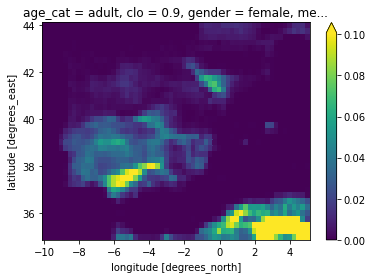

In [40]:
%%time
def plot_yearly_mean(da):
  weights = da.time.dt.daysinmonth
  (da.weighted(weights).mean('time') * da.encoding['scale_factor']).plot(robust=True)
plot_yearly_mean(ds_peth.heatstress_extreme)

CPU times: user 27.9 s, sys: 1.92 s, total: 29.8 s
Wall time: 11.4 s


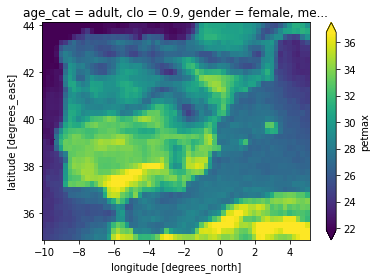

In [41]:
%%time
ds_peth.petmax.mean('time').plot(robust=True)  

### Daily maximum temperature

#### Historical

In [42]:
%%time
# Here we are only reading the metadata!
his = get_cached_remote_zarr("reanalysis-era5-land", 'copernicus-climate/spain.zarr')
print(his)

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, time: 14244)
Coordinates:
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 391 ms


In [43]:
%%time
# Monthly max tasmax
ds_tasmaxh = his.tasmax.resample(time='MS').max().sortby(['time', 'lon', 'lat'])
print(ds_tasmaxh)

<xarray.DataArray 'tasmax' (time: 468, lat: 91, lon: 151)>
dask.array<stack, shape=(468, 91, 151), dtype=float32, chunksize=(1, 91, 151), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-12-01
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
CPU times: user 742 ms, sys: 5.26 ms, total: 747 ms
Wall time: 740 ms


#### Longterm

In [44]:
# Define file name options
models = ['ACCESS1-0', 'BNU-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
experiments = ['rcp85', 'rcp45']
times = ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, model, experiment, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds['experiment'] = [experiment]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'experiment', 'model'])
  #ds[var] = ds[var].dt.days
  #ds = ds.rename_vars({var:f"coldsnap_{var}"})
  return ds

ds_list = list()
for e in experiments:
  for m in models:
    for t in times:
      fp = f"/content/dataset/tasmax/tasmax_{m}_{e}_Spain_{t}.nc"
      model = m
      experiment = e
      time = pd.to_datetime(t)
      ds_list.append(prep_dataset(fp, model, experiment, time))

ds_tasmaxlt = xr.combine_by_coords(ds_list)
ds_tasmaxlt = ds_tasmaxlt.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Daily maximum near-surface (usually 2m) air temperature.',
    'history' : 'Hourly surface temperature (tas) values, derived from the ERA5-Land reanalysis, were converted to daily maximum (tasmax) values for the reference period (1986-2005). Projected future temperature anomalies for time-intervals of 20 years (e.g., 2010-2030, 2020-2040), derived from the results of 2 climate experiements (rcp45, and rcp85) 5 models carried out in the CMIP5 intercomparison, were added to the reference period.',
    'source' : 'ER5-Land and CIMP5 available from the Copernicus Climate Data Store.'
}
ds_tasmaxlt.attrs = attrs
ds_tasmaxlt.tasmax.attrs = {
    'long_name' : 'Daily Maximum Near-Surface Air Temperature',
    'units' : 'K',
    'standard_name' : 'daily_maximum_air_temperature',
    'type' : 'real',
    'Conventions' :'CF-1.7',
    'source' :'ECMWF',
    'institution' : 'European Centre for Medium-Range Weather Forecasts'
    }

# Chunk
ds_tasmaxlt = ds_tasmaxlt.sortby(['experiment', 'model', 'time', 'lon', 'lat']).chunk({'experiment':1})
ds_tasmaxlt

<xarray.Dataset>
Dimensions:     (experiment: 2, lat: 91, lon: 151, model: 5, time: 8)
Coordinates:
  * model       (model) object 'ACCESS1-0' 'BNU-ESM' ... 'NorESM1-M'
  * experiment  (experiment) object 'rcp45' 'rcp85'
  * time        (time) datetime64[ns] 2020-01-01 2030-01-01 ... 2090-01-01
  * lat         (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.7 43.8 43.9 44.0
  * lon         (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
Data variables:
    tasmax      (time, model, experiment, lat, lon) float32 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily maximum near-surface (usually 2m) air temperature.
    history:      Hourly surface temperature (tas) values, derived from the E...
    source:       ER5-Land and CIMP5 available from the Copernicus Climate Da...

#### Seasonal

In [45]:
# Define file name options
models = ['cmcc_3', 'dwd_2', 'ecmwf_5', 'meteo_france_7', 'ukmo_14', 'ncep_2']
times = ['2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, model, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'model'])
  return ds

ds_list = list()
for m in models:
    for t in times:
      fp = f"/content/dataset/tasmax/tasmax_seasonal_02_{t}_{m}.nc"
      model = m
      ts = t.split('_')
      time = pd.to_datetime(f"{ts[0]}-{ts[1]}-01")
      ds_list.append(prep_dataset(fp, model, time))

ds_tasmaxse = xr.combine_by_coords(ds_list)
ds_tasmaxse = ds_tasmaxse.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Daily maximum near-surface (usually 2m) air temperature.',
    'history' : '',
    'source' : 'Derived from `Seasonal forecast daily data on single levels from 2017 to present` and ERA5-Land available in the Copernicus Climate Data Store'
}
ds_tasmaxse.attrs = attrs
ds_tasmaxse.tasmax.attrs = {
    'long_name' : 'Daily Maximum Near-Surface Air Temperature',
    'units' : 'K',
    'standard_name' : 'daily_maximum_air_temperature',
    'type' : 'real',
    'Conventions' :'CF-1.7',
    'source' :'ECMWF',
    'institution' : 'European Centre for Medium-Range Weather Forecasts'
    }
# Chunk
ds_tasmaxse = ds_tasmaxse.sortby(['model', 'time', 'lon', 'lat']).chunk({'time':-1})
ds_tasmaxse


<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, model: 6, time: 6)
Coordinates:
  * model    (model) object 'cmcc_3' 'dwd_2' 'ecmwf_5' ... 'ncep_2' 'ukmo_14'
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2020-07-01
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
Data variables:
    tasmax   (time, model, lat, lon) float32 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily maximum near-surface (usually 2m) air temperature.
    history:      
    source:       Derived from `Seasonal forecast daily data on single levels...

### Daily minimum temperature

#### Historical

In [46]:
%%time
# Here we are only reading the metadata!
his = get_cached_remote_zarr("reanalysis-era5-land", 'copernicus-climate/spain.zarr')
print(his)

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, time: 14244)
Coordinates:
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
CPU times: user 21.4 ms, sys: 983 µs, total: 22.4 ms
Wall time: 85.3 ms


In [47]:
%%time
# Monthly min tasmin
ds_tasminh = his.tasmin.resample(time='MS').min().sortby(['time', 'lon', 'lat'])
print(ds_tasminh)

<xarray.DataArray 'tasmin' (time: 468, lat: 91, lon: 151)>
dask.array<stack, shape=(468, 91, 151), dtype=float32, chunksize=(1, 91, 151), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-12-01
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
CPU times: user 737 ms, sys: 6.51 ms, total: 744 ms
Wall time: 739 ms


#### Longterm

In [48]:
# Define file name options
models = ['ACCESS1-0', 'BNU-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
experiments = ['rcp85', 'rcp45']
times = ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, model, experiment, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds['experiment'] = [experiment]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'experiment', 'model'])
  #ds[var] = ds[var].dt.days
  #ds = ds.rename_vars({var:f"coldsnap_{var}"})
  return ds

ds_list = list()
for e in experiments:
  for m in models:
    for t in times:
      fp = f"/content/dataset/tasmin/tasmin_{m}_{e}_Spain_{t}.nc"
      model = m
      experiment = e
      time = pd.to_datetime(t)
      ds_list.append(prep_dataset(fp, model, experiment, time))

ds_tasminlt = xr.combine_by_coords(ds_list)
ds_tasminlt = ds_tasminlt.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Daily minimum near-surface (usually 2m) air temperature.',
    'history' : 'Hourly surface temperature (tas) values, derived from the ERA5-Land reanalysis, were converted to daily minimum (tasmin) values for the reference period (1986-2005). Projected future temperature anomalies for time-intervals of 20 years (e.g., 2010-2030, 2020-2040), derived from the results of 2 climate experiements (rcp45, and rcp85) 5 models carried out in the CMIP5 intercomparison, were added to the reference period.',
    'source' : 'ER5-Land and CIMP5 available from the Copernicus Climate Data Store.'
}
ds_tasminlt.attrs = attrs
ds_tasminlt.tasmin.attrs = {
    'long_name' : 'Daily Minimum Near-Surface Air Temperature',
    'units' : 'K',
    'standard_name' : 'daily_minimum_air_temperature',
    'type' : 'real',
    'Conventions' :'CF-1.7',
    'source' :'ECMWF',
    'institution' : 'European Centre for Medium-Range Weather Forecasts'
    }

# Chunk
ds_tasminlt = ds_tasminlt.sortby(['experiment', 'model', 'time', 'lon', 'lat']).chunk({'experiment':1})
ds_tasminlt

<xarray.Dataset>
Dimensions:     (experiment: 2, lat: 91, lon: 151, model: 5, time: 8)
Coordinates:
  * model       (model) object 'ACCESS1-0' 'BNU-ESM' ... 'NorESM1-M'
  * experiment  (experiment) object 'rcp45' 'rcp85'
  * time        (time) datetime64[ns] 2020-01-01 2030-01-01 ... 2090-01-01
  * lat         (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.7 43.8 43.9 44.0
  * lon         (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
Data variables:
    tasmin      (time, model, experiment, lat, lon) float32 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily minimum near-surface (usually 2m) air temperature.
    history:      Hourly surface temperature (tas) values, derived from the E...
    source:       ER5-Land and CIMP5 available from the Copernicus Climate Da...

#### Seasonal

In [49]:
# Define file name options
models = ['cmcc_3', 'dwd_2', 'ecmwf_5', 'meteo_france_7', 'ukmo_14', 'ncep_2']
times = ['2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, model, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'model'])
  return ds

ds_list = list()
for m in models:
    for t in times:
      fp = f"/content/dataset/tasmin/tasmin_seasonal_02_{t}_{m}.nc"
      model = m
      ts = t.split('_')
      time = pd.to_datetime(f"{ts[0]}-{ts[1]}-01")
      ds_list.append(prep_dataset(fp, model, time))

ds_tasminse = xr.combine_by_coords(ds_list)
ds_tasminse = ds_tasminse.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Daily minimum near-surface (usually 2m) air temperature.',
    'history' : '',
    'source' : 'Derived from `Seasonal forecast daily data on single levels from 2017 to present` and ERA5-Land available in the Copernicus Climate Data Store'
}
ds_tasminse.attrs = attrs
ds_tasminse.tasmin.attrs = {
    'long_name' : 'Daily Minimum Near-Surface Air Temperature',
    'units' : 'K',
    'standard_name' : 'daily_minimum_air_temperature',
    'type' : 'real',
    'Conventions' :'CF-1.7',
    'source' :'ECMWF',
    'institution' : 'European Centre for Medium-Range Weather Forecasts'
    }
# Chunk
ds_tasminse = ds_tasminse.sortby(['model', 'time', 'lon', 'lat']).chunk({'time':-1})
ds_tasminse


<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, model: 6, time: 6)
Coordinates:
  * model    (model) object 'cmcc_3' 'dwd_2' 'ecmwf_5' ... 'ncep_2' 'ukmo_14'
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2020-07-01
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
Data variables:
    tasmin   (time, model, lat, lon) float32 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily minimum near-surface (usually 2m) air temperature.
    history:      
    source:       Derived from `Seasonal forecast daily data on single levels...

### Cold snaps

#### Historical

In [50]:
%%time
# Here we are only reading the metadata!
his = get_cached_remote_zarr("reanalysis-era5-land", 'copernicus-climate/spain.zarr')
print(his)

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, time: 14244)
Coordinates:
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 36.3 ms


In [51]:
%%time
# Calculate colde snaps using 0.05 quantile per cell for time interval 1981--2019
da_tasmin =  his.tasmin.chunk({'time':-1})
da_tasmin_reference =  his.tasmin.chunk({'time':-1})
ds_csh = cold_spell_frequency(da_tasmin, da_tasmin_reference, quantile=0.05, windows=[2,4,5], names=['warnings', 'alerts', 'alarms'], freq='MS')
ds_csh = ds_csh.sortby(['time', 'lon', 'lat'])
print(ds_csh)

<xarray.Dataset>
Dimensions:            (lat: 91, lon: 151, time: 468)
Coordinates:
  * time               (time) datetime64[ns] 1981-01-01 ... 2019-12-01
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
Data variables:
    coldsnap_warnings  (time, lat, lon) int16 dask.array<chunksize=(1, 91, 151), meta=np.ndarray>
    coldsnap_alerts    (time, lat, lon) int16 dask.array<chunksize=(1, 91, 151), meta=np.ndarray>
    coldsnap_alarms    (time, lat, lon) int16 dask.array<chunksize=(1, 91, 151), meta=np.ndarray>
CPU times: user 57.2 s, sys: 556 ms, total: 57.7 s
Wall time: 57.1 s


#### Longterm

In [52]:
# Define file name options
models = ['ACCESS1-0', 'BNU-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
experiments = ['rcp85', 'rcp45']
risk_longterm = ['Alarms', 'Alerts', 'Warnings']
times = ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, var, model, experiment, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds['experiment'] = [experiment]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'experiment', 'model'])
  #ds = ds.set_index(time='time', lat='latitude', lon='longitude', experiment='experiment', model='model')
  ds[var] = ds[var].dt.days
  ds = ds.rename_vars({var:f"coldsnap_{var}"})
  return ds

ds_list = list()
for v in risk_longterm:
  for e in experiments:
    for m in models:
      for t in times:
        fp = f"/content/dataset/coldsnaps/coldSpell{v}_{m}_{e}_Spain_{t}.nc"
        var = v.lower()
        model = m
        experiment = e
        time = pd.to_datetime(t)
        ds_list.append(prep_dataset(fp, var, model, experiment, time))

ds_cslt = xr.combine_by_coords(ds_list)
ds_cslt = ds_cslt.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Number of Cold snap events, defined as a period of consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005). A Warning event represents this condition for 1 to 2 consecutive days, an Alert event is 3 to 4 days, and an Alarm event lasts more than 4 days.',
    'history' : 'Hourly surface temperature (tas) values, derived from the ERA5-Land reanalysis, were converted to minimum daily (tasmin) values for the reference period (1986-2005), and the 0.05 quantile (tasmin_0.05) calculated per cell. Projected future temperature anomalies for future time-intervals of 20 years (e.g., 2010-2030, 2020-2040), derived from the results of 2 climate experiements (rcp45, and rcp85) 5 models carried out in the CMIP5 intercomparison, were added to the reference period, and the number of events were tasmin was less than tasmin_0.05 for 2, 4 and 5 or more consecutive days  was calculated per cell.',
    'source' : 'Derived from CMIP5 and ER5-Land available in the Copernicus Climate Data Store'
}
ds_cslt.attrs = attrs
ds_cslt.coldsnap_alarms.attrs = {'longname' : "number_of_cold_snap_alarm_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of more than 4 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}
ds_cslt.coldsnap_alerts.attrs = {'longname' : "number_of_cold_snap_alert_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of 3-4 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'} 
ds_cslt.coldsnap_warnings.attrs = {'longname' : "number_of_cold_snap_warning_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of 1-2 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}

# Chunk
ds_cslt = ds_cslt.sortby(['experiment', 'model', 'time', 'lon', 'lat']).chunk({'experiment':1})
ds_cslt

<xarray.Dataset>
Dimensions:            (experiment: 2, lat: 91, lon: 151, model: 5, time: 8)
Coordinates:
  * model              (model) object 'ACCESS1-0' 'BNU-ESM' ... 'NorESM1-M'
  * experiment         (experiment) object 'rcp45' 'rcp85'
  * time               (time) datetime64[ns] 2020-01-01 ... 2090-01-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    coldsnap_alarms    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    coldsnap_alerts    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    coldsnap_warnings  (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
Attributes:
    description:  Number of Cold snap events, defined as a period of consecut...
    history:      Hourly surface temperature (tas) values, derived from the E...
    source:       Derived from CMIP5 and ER5-Land available in the Copernicus...

#### Seasonal

In [53]:
# Define file name options
models = ['cmcc_3', 'dwd_2', 'ecmwf_5', 'meteo_france_7', 'ukmo_14', 'ncep_2']
risk_longterm = ['alarm', 'alert', 'warning']
times = ['2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, var, model, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'model'])
  var = f"{var}s"
  ds[var] = ds[var].dt.days
  ds = ds.rename_vars({var:f"coldsnap_{var}"})
  return ds

ds_list = list()
for v in risk_longterm:
    for m in models:
      for t in times:
        fp = f"/content/dataset/coldsnaps/coldspell_{v}_seasonal_02_{t}_{m}.nc"
        var = v.lower()
        model = m
        ts = t.split('_')
        time = pd.to_datetime(f"{ts[0]}-{ts[1]}-01")
        ds_list.append(prep_dataset(fp, var, model, time))

ds_csse = xr.combine_by_coords(ds_list)
ds_csse = ds_csse.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Number of Cold snap events, defined as a period of consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005). A Warning event represents this condition for 1 to 2 consecutive days, an Alert event is 3 to 4 days, and an Alarm event lasts more than 4 days.',
    'history' : 'Hourly surface temperature (tas) values, derived from the ERA5-Land reanalysis, were converted to minimum daily (tasmin) values for the reference period (1986-2005), and the 0.05 quantile (tasmin_0.05) calculated per cell. Projected future temperature anomalies for future time-intervals of 20 years (e.g., 2010-2030, 2020-2040), derived from the results of 2 climate experiements (rcp45, and rcp85) 5 models carried out in the CMIP5 intercomparison, were added to the reference period, and the number of events were tasmin was less than tasmin_0.05 for 2, 4 and 5 or more consecutive days  was calculated per cell.',
    'source' : 'Derived from `Seasonal forecast daily data on single levels from 2017 to present` and ERA5-Land available in the Copernicus Climate Data Store'
}
ds_csse.attrs = attrs
ds_csse.coldsnap_alarms.attrs = {'longname' : "number_of_cold_snap_alarm_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of more than 4 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}
ds_csse.coldsnap_alerts.attrs = {'longname' : "number_of_cold_snap_alert_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of 3-4 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'} 
ds_csse.coldsnap_warnings.attrs = {'longname' : "number_of_cold_snap_warning_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of 1-2 consecutive days when the minimum daily temperature (tasmin) is lower than the 0.05 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}

# Chunk
ds_csse = ds_csse.sortby(['model', 'time', 'lon', 'lat']).chunk({'time':-1})
ds_csse


<xarray.Dataset>
Dimensions:            (lat: 91, lon: 151, model: 6, time: 6)
Coordinates:
  * model              (model) object 'cmcc_3' 'dwd_2' ... 'ncep_2' 'ukmo_14'
  * time               (time) datetime64[ns] 2020-02-01 ... 2020-07-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    coldsnap_alarms    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    coldsnap_alerts    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    coldsnap_warnings  (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
Attributes:
    description:  Number of Cold snap events, defined as a period of consecut...
    history:      Hourly surface temperature (tas) values, derived from the E...
    source:       Derived from `Seasonal forecast daily data on single levels...

### Heatwaves

#### Historical

In [54]:
%%time
# Here we are only reading the metadata!
his = get_cached_remote_zarr("reanalysis-era5-land", 'copernicus-climate/spain.zarr')
print(his)

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, time: 14244)
Coordinates:
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
CPU times: user 21.4 ms, sys: 1.01 ms, total: 22.4 ms
Wall time: 45.5 ms


In [0]:
#%%time
# Calculate heatwaves using quantiles per cell for time interval 1981--2019
da_tasmin =  his.tasmin.chunk({'time':-1})
da_tasmax =  his.tasmax.chunk({'time':-1})
ds_reference =  his.chunk({'time':-1})
ds_hwh = heat_wave_frequency(da_tasmax,
                        da_tasmin,
                        ds_reference,
                        quantiles={'tasmin':0.90, 'tasmax':0.95},
                        windows=[2,4,5],
                        names=['warnings', 'alerts', 'alarms'],
                        freq='MS')
ds_hwh = ds_hwh.sortby(['time', 'lon', 'lat'])

#### Longterm

In [56]:
# Define file name options
models = ['ACCESS1-0', 'BNU-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
experiments = ['rcp85', 'rcp45']
risk_longterm = ['Alarms', 'Alerts', 'Warnings2']
times = ['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, var, model, experiment, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds['experiment'] = [experiment]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'experiment', 'model'])
  ds[var] = ds[var].dt.days
  ds = ds.rename_vars({var:f"heatwave_{var}"})
  return ds

ds_list = list()
for v in risk_longterm:
  for e in experiments:
    for m in models:
      for t in times:
        fp = f"/content/dataset/heatwaves/heatwaves{v}_{m}_{e}_Spain_{t}.nc"
        var = v.lower().split('2')[0]
        model = m
        experiment = e
        time = pd.to_datetime(t)
        ds_list.append(prep_dataset(fp, var, model, experiment, time))

ds_hwlt = xr.combine_by_coords(ds_list)
ds_hwlt = ds_hwlt.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Number of Heatwave events, defined as a period of consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005). A Warning event represents this condition for 2 consecutive days, an Alert event is 3 to 4 days, and an Alarm event lasts more than 4 days.',
    'history' : 'Hourly surface temperature (tas) values, derived from the ERA5-Land reanalysis, were converted to daily maximum (tasmax) and minimum (tasmin) values for the reference period (1986-2005), and the 0.95 (tasmax_0.95) and 0.9 (tasmin_0.9) quantiles for tasmax and tasmin, respectivly were calculated per cell. Projected future temperature anomalies for future time-intervals of 20 years (e.g., 2010-2030, 2020-2040), derived from the results of 2 climate experiements (rcp45, and rcp85) 5 models carried out in the CMIP5 intercomparison, were added to the reference period, and the number of events were tasmax and tasmin were more than tasmax_0.95 and tasmin_0.90 for 2, 4 and 5 or more consecutive days  was calculated per cell.',
    'source' : 'Derived from CMIP5 and ER5-Land available in the Copernicus Climate Data Store'
}
ds_hwlt.attrs = attrs
ds_hwlt.heatwave_alarms.attrs = {'longname' : "number_of_heat_wave_alarm_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of more than 4 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}
ds_hwlt.heatwave_alerts.attrs = {'longname' : "number_of_heat_wave_alert_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of 3-4 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'} 
ds_hwlt.heatwave_warnings.attrs = {'longname' : "number_of_heat_wave_warning_events_in_time_period", 'units' : "number_of_events_per_20_years", 'description': 'Defined as a period of 2 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}

# Chunk
ds_hwlt = ds_hwlt.sortby(['experiment', 'model', 'time', 'lon', 'lat']).chunk({'experiment':1})
ds_hwlt

<xarray.Dataset>
Dimensions:            (experiment: 2, lat: 91, lon: 151, model: 5, time: 8)
Coordinates:
  * model              (model) object 'ACCESS1-0' 'BNU-ESM' ... 'NorESM1-M'
  * experiment         (experiment) object 'rcp45' 'rcp85'
  * time               (time) datetime64[ns] 2020-01-01 ... 2090-01-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    heatwave_alarms    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    heatwave_alerts    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    heatwave_warnings  (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
Attributes:
    description:  Number of Heatwave events, defined as a period of consecuti...
    history:      Hourly surface temperature (tas) values, derived from the E...
    source:       Derived from CMIP5 and ER5-Land available in the Copernicus...

#### Seasonal

In [57]:
# Define file name options
models = ['cmcc_3', 'dwd_2', 'ecmwf_5', 'meteo_france_7', 'ukmo_14', 'ncep_2']
risk_longterm = ['alarm', 'alert', 'warning2']
times = ['2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07']

# Combine datasets
import xarray as xr
import pandas as pd
import datetime

def prep_dataset(fp, var, model, time):
  ds = xr.open_dataset(fp)
  ds['model'] = [model]
  ds['time'] = [time]
  ds = ds.set_coords(['time', 'longitude', 'latitude', 'model'])
  var = f"{var}s"
  ds[var] = ds[var].dt.days
  ds = ds.rename_vars({var:f"heatwave_{var}"})
  return ds

ds_list = list()
for v in risk_longterm:
    for m in models:
      for t in times:
        fp = f"/content/dataset/heatwaves/heatwave_{v}_seasonal_02_{t}_{m}.nc"
        var = v.lower().split('2')[0]
        model = m
        ts = t.split('_')
        time = pd.to_datetime(f"{ts[0]}-{ts[1]}-01")
        ds_list.append(prep_dataset(fp, var, model, time))

ds_hwse = xr.combine_by_coords(ds_list)
ds_hwse = ds_hwse.set_index(lat='latitude', lon='longitude', append=True)

# Create attributes
attrs = {
    'description' : 'Number of Heatwave events, defined as a period of consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005). A Warning event represents this condition for 2 consecutive days, an Alert event is 3 to 4 days, and an Alarm event lasts more than 4 days.',
    'history' : '',
    'source' : 'Derived from `Seasonal forecast daily data on single levels from 2017 to present` and ER5-Land available in the Copernicus Climate Data Store'
}
ds_hwse.attrs = attrs
ds_hwse.heatwave_alarms.attrs = {'longname' : "number_of_heatwave_alarm_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of more than 4 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}
ds_hwse.heatwave_alerts.attrs = {'longname' : "number_of_heatwave_alert_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of more than 4 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'} 
ds_hwse.heatwave_warnings.attrs = {'longname' : "number_of_heatwave_warning_events_in_time_period", 'units' : "number_of_events_per_month", 'description': 'Defined as a period of more than 4 consecutive days when the daily maximum temperature (tasmax) is higher than the 0.95 quantile and daily minimum temperature (tasmin) exceeds the 0.9 quantile observed in the corresponding grid cell of the reference period (1986-2005).'}

# Chunk
ds_hwse = ds_hwse.sortby(['model', 'time', 'lon', 'lat']).chunk({'time':-1})
ds_hwse


<xarray.Dataset>
Dimensions:            (lat: 91, lon: 151, model: 6, time: 6)
Coordinates:
  * model              (model) object 'cmcc_3' 'dwd_2' ... 'ncep_2' 'ukmo_14'
  * time               (time) datetime64[ns] 2020-02-01 ... 2020-07-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    heatwave_alarms    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    heatwave_alerts    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    heatwave_warnings  (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
Attributes:
    description:  Number of Heatwave events, defined as a period of consecuti...
    history:      
    source:       Derived from `Seasonal forecast daily data on single levels...

## Merge historical, seasonal, and longterm 

In [0]:
# interpolate PET to other grids
ds_pethi = ds_peth.chunk({'time':-1}).interp_like(ds_tasmaxh)
#ds_pethi.petmax.sel(time='2015-08-01').plot()

In [59]:
historical = xr.merge([ds_tasmaxh, ds_tasminh, ds_csh, ds_hwh, ds_pethi])
# Create attributes
attrs = {
    'description' : 'Daily maximum near-surface (usually 2m) air temperature, daily minimum near-surface (usually 2m) air temperature, cold snap and heatwave alarms, alerts and warnings, and maximum Physiologically Equivalent Temperature (PET).',
    'history' : '',
    'source' : 'Derived from ERA5, `Thermal-comfort-indices-derived-from-ERA5-reanalysis`, and ERA5-Land available in the Copernicus Climate Data Store'
}
historical.attrs = attrs
historical = historical.chunk({'time':24*5})
historical

<xarray.Dataset>
Dimensions:              (lat: 91, lon: 151, time: 468)
Coordinates:
  * time                 (time) datetime64[ns] 1981-01-01 ... 2019-12-01
  * lat                  (lat) float64 35.0 35.1 35.2 35.3 ... 43.8 43.9 44.0
  * lon                  (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
    age_cat              <U5 'adult'
    clo                  float64 0.9
    gender               <U6 'female'
    met                  float64 80.0
Data variables:
    tasmax               (time, lat, lon) float32 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    tasmin               (time, lat, lon) float32 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldsnap_warnings    (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldsnap_alerts      (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldsnap_alarms      (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatwave_warnings    (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatwave_alerts      (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatwave_alarms      (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatstress_moderate  (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatstress_strong    (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    heatstress_extreme   (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldstress_moderate  (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldstress_strong    (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    coldstress_extreme   (time, lat, lon) int16 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    petmax               (time, lat, lon) float32 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
    petmin               (time, lat, lon) float32 dask.array<chunksize=(120, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily maximum near-surface (usually 2m) air temperature, da...
    history:      
    source:       Derived from ERA5, `Thermal-comfort-indices-derived-from-ER...

In [60]:
seasonal = xr.merge([ds_tasmaxse, ds_tasminse, ds_csse, ds_hwse])
# Create attributes
attrs = {
    'description' : 'Daily maximum near-surface (usually 2m) air temperature, daily minimum near-surface (usually 2m) air temperature, cold snap and heatwave alarms, alerts and warnings.',
    'history' : '',
    'source' : 'Derived from `Seasonal forecast daily data on single levels from 2017 to present`, and ERA5-Land available in the Copernicus Climate Data Store'
}
seasonal.attrs = attrs
seasonal 

<xarray.Dataset>
Dimensions:            (lat: 91, lon: 151, model: 6, time: 6)
Coordinates:
  * model              (model) object 'cmcc_3' 'dwd_2' ... 'ncep_2' 'ukmo_14'
  * time               (time) datetime64[ns] 2020-02-01 ... 2020-07-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    tasmax             (time, model, lat, lon) float32 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    tasmin             (time, model, lat, lon) float32 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    coldsnap_alarms    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    coldsnap_alerts    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    coldsnap_warnings  (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    heatwave_alarms    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    heatwave_alerts    (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
    heatwave_warnings  (time, model, lat, lon) float64 dask.array<chunksize=(6, 6, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily maximum near-surface (usually 2m) air temperature, da...
    history:      
    source:       Derived from `Seasonal forecast daily data on single levels...

In [61]:
longterm = xr.merge([ds_tasmaxlt, ds_tasminlt, ds_cslt, ds_hwlt])
# Create attributes
attrs = {
    'description' : 'Daily maximum near-surface (usually 2m) air temperature, daily minimum near-surface (usually 2m) air temperature, cold snap and heatwave alarms, alerts and warnings.',
    'history' : '',
    'source' : 'Derived from ERA5-Land, and CIMP5 available in the Copernicus Climate Data Store'
}
longterm.attrs = attrs
longterm

<xarray.Dataset>
Dimensions:            (experiment: 2, lat: 91, lon: 151, model: 5, time: 8)
Coordinates:
  * model              (model) object 'ACCESS1-0' 'BNU-ESM' ... 'NorESM1-M'
  * experiment         (experiment) object 'rcp45' 'rcp85'
  * time               (time) datetime64[ns] 2020-01-01 ... 2090-01-01
  * lat                (lat) float64 35.0 35.1 35.2 35.3 ... 43.7 43.8 43.9 44.0
  * lon                (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.7 4.8 4.9 5.0
Data variables:
    tasmax             (time, model, experiment, lat, lon) float32 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    tasmin             (time, model, experiment, lat, lon) float32 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    coldsnap_alarms    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    coldsnap_alerts    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    coldsnap_warnings  (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    heatwave_alarms    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    heatwave_alerts    (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
    heatwave_warnings  (time, model, experiment, lat, lon) float64 dask.array<chunksize=(8, 5, 1, 91, 151), meta=np.ndarray>
Attributes:
    description:  Daily maximum near-surface (usually 2m) air temperature, da...
    history:      
    source:       Derived from ERA5-Land, and CIMP5 available in the Copernic...

### Write to Zarr

In [0]:
# Remove previous zarr to ensure no data conversion issues
#rmv_remote_zarr(group = 'historical-monthly', root = "copernicus-climate/spain.zarr", show_tree=False)

In [63]:
%%time
# Create remote ZARR
write_to_remote_zarr(historical, group = 'historical-monthly', root = "copernicus-climate/spain.zarr", show_tree=False)

copernicus-climate/spain.zarr is consoldiated? True
CPU times: user 2min 13s, sys: 15.4 s, total: 2min 28s
Wall time: 2min 8s


In [64]:
%%time
write_to_remote_zarr(seasonal, group = 'future-seasonal-monthly', root = "copernicus-climate/spain.zarr", show_tree=False)

copernicus-climate/spain.zarr is consoldiated? True
CPU times: user 2.27 s, sys: 121 ms, total: 2.39 s
Wall time: 26.8 s


In [65]:
%%time
write_to_remote_zarr(longterm, group = 'future-longterm-yr10', root = "copernicus-climate/spain.zarr")

copernicus-climate/spain.zarr is consoldiated? True
/
 ├── future-longterm-yr10
 │   ├── coldsnap_alarms (8, 5, 2, 91, 151) float64
 │   ├── coldsnap_alerts (8, 5, 2, 91, 151) float64
 │   ├── coldsnap_warnings (8, 5, 2, 91, 151) float64
 │   ├── experiment (2,) object
 │   ├── heatwave_alarms (8, 5, 2, 91, 151) float64
 │   ├── heatwave_alerts (8, 5, 2, 91, 151) float64
 │   ├── heatwave_warnings (8, 5, 2, 91, 151) float64
 │   ├── lat (91,) float64
 │   ├── lon (151,) float64
 │   ├── model (5,) object
 │   ├── tasmax (8, 5, 2, 91, 151) float32
 │   ├── tasmin (8, 5, 2, 91, 151) float32
 │   └── time (8,) int64
 ├── future-seasonal-monthly
 │   ├── coldsnap_alarms (6, 6, 91, 151) float64
 │   ├── coldsnap_alerts (6, 6, 91, 151) float64
 │   ├── coldsnap_warnings (6, 6, 91, 151) float64
 │   ├── heatwave_alarms (6, 6, 91, 151) float64
 │   ├── heatwave_alerts (6, 6, 91, 151) float64
 │   ├── heatwave_warnings (6, 6, 91, 151) float64
 │   ├── lat (91,) float64
 │   ├── lon (151,) float

In [66]:
get_size_remote_zarr(None, 'copernicus-climate/spain.zarr')

Processing: gsutil -m du -sh gs://copernicus-climate/spain.zarr
7.05 GiB     gs://copernicus-climate/spain.zarr


In [67]:
# Total time
#elapsed_time_secs = time.time() - start_time
#elapsed_time_secs = timedelta(seconds=round(elapsed_time_secs))
#msg = f"Execution took: {elapsed_time_secs} secs (Wall clock time)" 
#print(msg)    

TypeError: ignored